In [3]:
import torch
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm

from torch import nn
import torch.nn.functional as F

random.seed(42)

In [4]:
data_dir = '../osic-pulmonary-fibrosis-progression'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "preprocessing")))

from preprocess import preprocess_scans
import pickle

if not os.path.exists(f'{data_dir}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir)
    pickle.dump(preprocessed_scans, open(f'{data_dir}/preprocessed_scans.pkl', 'wb'))

Using device: cuda


In [6]:
# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [7]:
# Prepare train and val data
train_datas = pd.read_csv(data_dir + '/train.csv')
test_datas = pd.read_csv(data_dir + '/test.csv')

test_patient_ids = test_datas['Patient'].unique()

# Remove row in train data if patient_id is in test_patient_ids
test_datas = train_datas[train_datas['Patient'].isin(test_patient_ids)]
train_datas = train_datas[~train_datas['Patient'].isin(test_patient_ids)]

# Sort df by patient and then by 'Weeks'
train_datas = train_datas.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value and weeks
patient_id_to_initial_FVC = train_datas.groupby('Patient')['FVC'].first().to_dict()
patient_id_to_initial_weeks = train_datas.groupby('Patient')['Weeks'].first().to_dict()

train_datas, val_datas = train_val_split(train_datas)

# Count the number of scans for each patient
scan_count = {}
test_scan_count = {}
for patient_id in os.listdir(os.path.join(data_dir, 'train')):
    scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'train', patient_id)))
    
    if patient_id in test_patient_ids:
        test_scan_count[patient_id] = len(os.listdir(os.path.join(data_dir, 'test', patient_id)))

test_patient_id_to_initial_FVC = test_datas.groupby('Patient')['FVC'].first().to_dict()
test_patient_id_to_initial_weeks = test_datas.groupby('Patient')['Weeks'].first().to_dict()

In [8]:
from collections import defaultdict

train_x, train_y = defaultdict(list), defaultdict(list)

for idx, row in train_datas.iterrows():
    train_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    train_y[row['Patient']].append(row['FVC'])

val_x, val_y = defaultdict(list), defaultdict(list)

for idx, row in val_datas.iterrows():
    val_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': patient_id_to_initial_weeks[row['Patient']],
    })
    val_y[row['Patient']].append(row['FVC'])

test_x, test_y = defaultdict(list), defaultdict(list)

for idx, row in test_datas.iterrows():
    test_x[row['Patient']].append({
        'Weeks': row['Weeks'],
        'initial_FVC': test_patient_id_to_initial_FVC[row['Patient']],
        'initial_weeks': test_patient_id_to_initial_weeks[row['Patient']],
    })
    test_y[row['Patient']].append(row['FVC'])


In [9]:
# Use training data to gather tabular data statistics
# Compute statistics
tabular_stats = {
    'weeks_mean': train_datas['Weeks'].mean(),
    'weeks_std': train_datas['Weeks'].std(),
    'initial_fvc_mean': train_datas['FVC'].mean(),
    'initial_fvc_std': train_datas['FVC'].std(),
    'initial_weeks_mean': train_datas['Weeks'].mean(),
    'initial_weeks_std': train_datas['Weeks'].std(),
}

print("Normalization Statistics:")
print(f"Weeks: mean={tabular_stats['weeks_mean']:.2f}, std={tabular_stats['weeks_std']:.2f}")
print(f"FVC:   mean={tabular_stats['initial_fvc_mean']:.2f}, std={tabular_stats['initial_fvc_std']:.2f}")
print(f"Weeks: mean={tabular_stats['initial_weeks_mean']:.2f}, std={tabular_stats['initial_weeks_std']:.2f}")

Normalization Statistics:
Weeks: mean=30.56, std=22.37
FVC:   mean=2696.73, std=839.28
Weeks: mean=30.56, std=22.37


In [10]:
import matplotlib.pyplot as plt
import math

# window = 0 to remove smoothing
def plot_loss(training_loss, val_loss, window=20):
    # Use sliding window to smooth the loss
    training_loss = [sum(training_loss[i:i+window]) / window for i in range(len(training_loss)-window)]
    val_loss = [sum(val_loss[i:i+window]) / window for i in range(len(val_loss)-window)]

    # Create one row, two col subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].plot(range(len(training_loss)), [math.log(x) for x in training_loss], label='Training Loss')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(range(len(val_loss)), [math.log(x) for x in val_loss], label='Validation Loss', color='orange')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    axs[1].legend()

In [11]:
from preprocess import get_preprocessed_scan

def get_scans(patient_id: str, patient_scan_count: int, scan_batch_size: int) -> torch.Tensor:
    skip_size = max(1, round(patient_scan_count / scan_batch_size))
    scans = []
    for j in range(1, patient_scan_count + 1, skip_size):
        scan = get_preprocessed_scan(data_dir, patient_id, j)
        if scan is None:
            continue
        scan = torch.tensor(scan, dtype=torch.float32, device=device)
        scans.append(scan)
    scans = torch.stack(scans)
    return scans

In [12]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_model, fc_model, scan_batch_size=64):
    cnn_model.to(device)
    fc_model.to(device)

    cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
        features = cnn_model.forward(scans)
        features = torch.mean(features, dim=0) # 1024,

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

In [13]:
# Quick visualization
def plot_test_results(targets, predictions, losses):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Left: Scatter
    ax[0].scatter(targets, predictions, alpha=0.5)
    ax[0].plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    ax[0].set_xlabel('Target')
    ax[0].set_ylabel('Prediction')
    ax[0].set_title('Predictions vs Targets')

    # Right: Loss
    ax[1].plot(losses)
    ax[1].set_xlabel('Sample')
    ax[1].set_ylabel('Loss')
    ax[1].set_yscale('log')
    ax[1].set_title('Loss per Sample')

    plt.tight_layout()
    plt.show()

In [88]:

def plot_patient_predict_samples(cnn_model, fc_model):
    cnn_model.eval()
    fc_model.eval()
    criterion = torch.nn.MSELoss()

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    # avg_loss = 0
    # for patient_id in list(train_x.keys()):
    #     scans = get_scans(patient_id, scan_count[patient_id], 64)
    #     features = torch.mean(cnn_model.forward(scans), dim=0)
    #     x = train_x[patient_id]
    #     y = train_y[patient_id]

    #     for i in range(len(x)):
    #         weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
    #         initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
    #         output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
    #         avg_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)).item()
    
    # avg_loss /= len(list(train_x.keys()))
    # print(f'Average Loss: {avg_loss}')
            
    for patient_order, patient in enumerate(list(train_x.keys())[10:14]):
        scans = get_scans(patient, scan_count[patient], 64)
        features = torch.mean(cnn_model.forward(scans), dim=0)
        x = train_x[patient]
        y = train_y[patient]

        predictions = []
        losses = []
        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            predictions.append(output.item())
            losses.append(criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device)))
        
        print(f'{patient} Average Loss: {sum(losses) / len(losses)}')

        # # Visualize activation levels as a line plot
        # norm_weeks = (weeks - tabular_stats['weeks_mean']) / tabular_stats['weeks_std']
        # norm_initial_FVC = (initial_FVC - tabular_stats['initial_fvc_mean']) / tabular_stats['initial_fvc_std']
        # norm_initial_FVC_weeks = (initial_FVC_weeks - tabular_stats['initial_weeks_mean']) / tabular_stats['initial_weeks_std']
        # tab_features = torch.cat([norm_weeks, norm_initial_FVC, norm_initial_FVC_weeks])
        # tab_features = F.relu(fc_model.tabular_expansion_fc1(tab_features))
        # tab_features = F.relu(fc_model.tabular_expansion_fc2(tab_features))
        # combined_features = torch.cat([features, tab_features])
        
        # feat = fc_model.fc1(combined_features)
        # feat = F.relu(feat)
        # feat = fc_model.fc2(feat)
        # feat = F.relu(feat)
        # print(feat)
        # feat = fc_model.fc3(feat)

        # How does 'week' feature affect the prediction?
        # weeks = torch.tensor(0, dtype=torch.float32, device=device).unsqueeze(0)
        # pred_week_0 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
        # weeks = torch.tensor(50, dtype=torch.float32, device=device).unsqueeze(0)
        # pred_week_50 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
        # weeks = torch.tensor(100, dtype=torch.float32, device=device).unsqueeze(0)
        # pred_week_100 = fc_model(features, weeks, initial_FVC, initial_FVC_weeks)
        # print(pred_week_0.item(), pred_week_50.item(), pred_week_100.item())

        row = patient_order // 2
        col = patient_order % 2

        # Plot prediction vs actual for each patient
        axes[row][col].scatter(range(len(y)), y, color='blue', alpha=0.7, s=80, label='Actual', edgecolors='darkblue', linewidth=0.5)
        axes[row][col].scatter(range(len(predictions)), predictions, color='red', alpha=0.7, s=80, label='Predicted', edgecolors='darkred', linewidth=0.5)
        
        axes[row][col].set_xlabel('Timepoints', fontsize=11, fontweight='bold')
        axes[row][col].set_ylabel('FVC', fontsize=11, fontweight='bold')
        axes[row][col].set_title(f'Patient {patient}', fontsize=12, fontweight='bold', pad=10)
        axes[row][col].legend(loc='best', frameon=True, shadow=True)
        axes[row][col].grid(True, alpha=0.3, linestyle='--')
        axes[row][col].tick_params(labelsize=10)

    # Add spacing between subplots
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)

    # Or alternatively, use subplots_adjust for more control:
    # plt.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95, hspace=0.3, wspace=0.3)

    plt.suptitle('FVC Predictions vs Actual Values', fontsize=16, fontweight='bold', y=0.995)
    del weeks, initial_FVC, initial_FVC_weeks, predictions, scans, features, output
    torch.cuda.empty_cache()
    plt.show()


In [15]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=32):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate gradient for 8 datapoints for each patient
            # total_loss = 0
            # patient_scan_count = scan_count[patient_id]
            # scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            # for i in range(0, len(x), 4):
            #     optimizer.zero_grad()
            #     features = cnn_model.forward(scans)
            #     features = torch.mean(features, dim=0) # 1024,
                
            #     chunk_loss = 0
            #     for j in range(i, min(len(x), i+4)):
            #         weeks = torch.tensor(x[j]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            #         initial_FVC = torch.tensor(x[j]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            #         initial_FVC_weeks = torch.tensor(x[j]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            #         # Forward Pass
            #         output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            #         loss = criterion(output, torch.tensor(y[j], dtype=torch.float32, device=device))
            #         chunk_loss += loss
            #         total_loss += loss.item()

            #     chunk_loss.backward()
            #     optimizer.step()
            
            total_loss = 0
            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            for i in range(len(x)):
                optimizer.zero_grad()
                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0) # 1024,

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()

            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

### Baseline Model with 5 Convolution Layers

In [ ]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = F.relu(self.bn1(self.conv1(scans)))
        x = self.pool(x) # num_slices, 32, 128, 128
    
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # num_slices, 64, 64, 64
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # num_slices, 128, 32, 32

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x) # num_slices, 256, 16, 16

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x) # num_slices, 512, 8, 8

        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)


        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [73]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_simple_cnn.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=20, scan_batch_size=64)

Epoch 0


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 0 completed
Training Loss: 201816.01791205633
Validation Loss: 721079.880237325
Epoch 1


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 1 completed
Training Loss: 502626.1520631821
Validation Loss: 304410.2135704189
Epoch 2


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 2 completed
Training Loss: 64171.100812324534
Validation Loss: 107570.90302025902
Epoch 3


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 3 completed
Training Loss: 61127.874334086315
Validation Loss: 79289.03445887248
Epoch 4


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 4 completed
Training Loss: 112664.8962776449
Validation Loss: 112998.21478851319
Epoch 5


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 5 completed
Training Loss: 41709.28348974784
Validation Loss: 73736.71894794147
Epoch 6


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 6 completed
Training Loss: 103477.38801123074
Validation Loss: 54644.43035713646
Epoch 7


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 7 completed
Training Loss: 45914.78552028868
Validation Loss: 54140.02369616615
Epoch 8


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 8 completed
Training Loss: 56157.907446522186
Validation Loss: 76053.5128076511
Epoch 9


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 9 completed
Training Loss: 57716.56013205847
Validation Loss: 53450.479450433515
Epoch 10


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 10 completed
Training Loss: 25237.736510687937
Validation Loss: 52757.26427754747
Epoch 11


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 11 completed
Training Loss: 20895.160103058814
Validation Loss: 59981.77643124686
Epoch 12


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 12 completed
Training Loss: 40695.86138066185
Validation Loss: 60443.51360255771
Epoch 13


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 13 completed
Training Loss: 82604.84121311188
Validation Loss: 50754.16986374378
Epoch 14


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 14 completed
Training Loss: 44013.115658563285
Validation Loss: 49145.32045108908
Epoch 15


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 15 completed
Training Loss: 68923.78140409259
Validation Loss: 60432.78392880606
Epoch 16


100%|██████████| 136/136 [01:52<00:00,  1.21it/s]


Epoch 16 completed
Training Loss: 52790.63551663611
Validation Loss: 95792.13201541477
Epoch 17


100%|██████████| 136/136 [01:52<00:00,  1.20it/s]


Epoch 17 completed
Training Loss: 39105.13443303638
Validation Loss: 52160.0744310909
Epoch 18


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 18 completed
Training Loss: 57638.160543478865
Validation Loss: 48743.689501373505
Epoch 19


100%|██████████| 136/136 [01:53<00:00,  1.20it/s]


Epoch 19 completed
Training Loss: 81977.89489631983
Validation Loss: 56916.187700051196


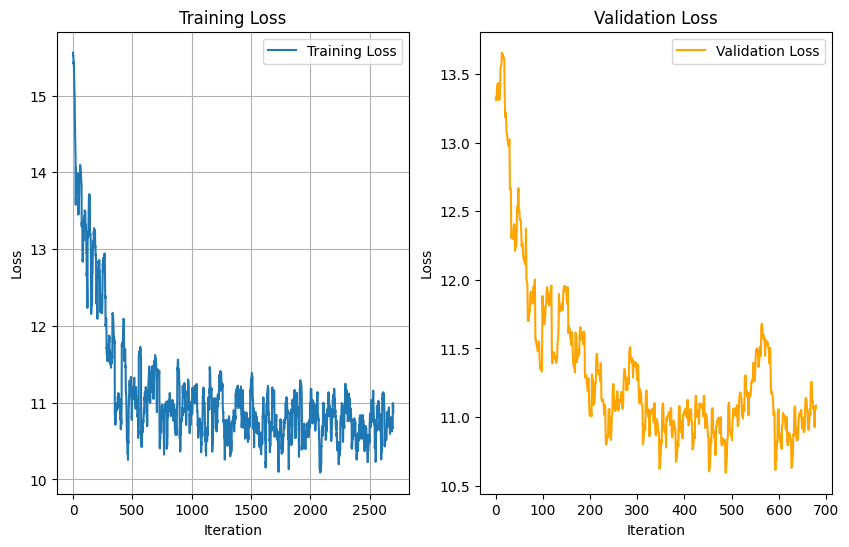

In [74]:
plot_loss(training_loss, val_loss)

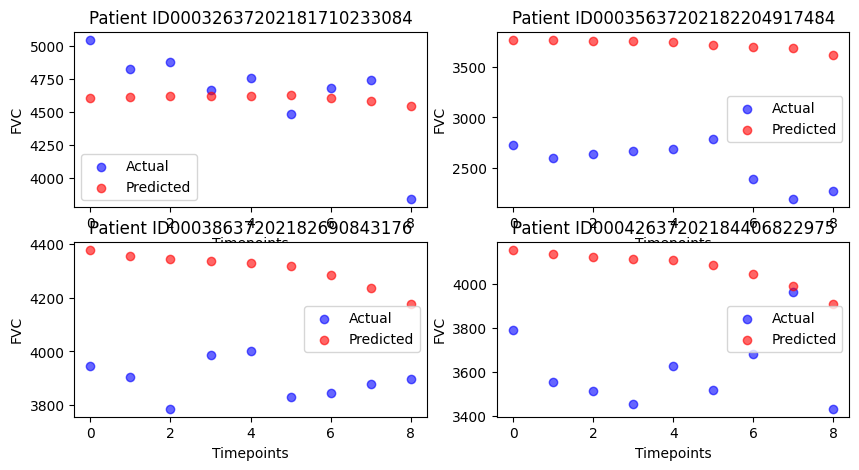

In [88]:
plot_patient_predict_samples(cnn_model, fc_model)

100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


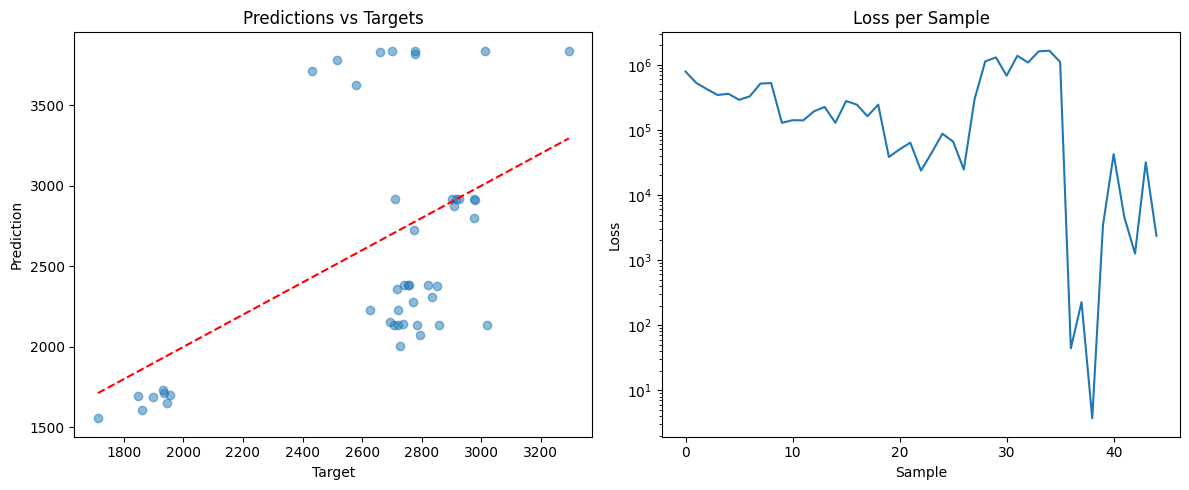

In [78]:
test_prediction, test_target = test_model(cnn_model, fc_model)
criterion = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [criterion(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

### Improvement to Baseline: Increased convolution layers using sequential blocks

In [71]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2, stride=2)
        self.pool1 = nn.MaxPool2d((3,3), stride=(2,2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(16, 128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(32, 256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(64, 512),
            # nn.ReLU(),
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 128, 128
        x = self.pool1(x) # num_slices, 64, 64, 64

        x = self.conv2(x) # num_slices, 64, 64, 64
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512, tabular_dim=30, tabular_norm_stats=None):
        super(FCLayer, self).__init__()
        self.tabular_norm_stats = tabular_norm_stats
        if tabular_norm_stats is not None:
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('weeks_mean', torch.tensor(tabular_norm_stats['weeks_mean']))
            self.register_buffer('weeks_std', torch.tensor(tabular_norm_stats['weeks_std']))
            self.register_buffer('initial_fvc_mean', torch.tensor(tabular_norm_stats['initial_fvc_mean']))
            self.register_buffer('initial_fvc_std', torch.tensor(tabular_norm_stats['initial_fvc_std']))
            self.register_buffer('initial_weeks_mean', torch.tensor(tabular_norm_stats['initial_weeks_mean']))
            self.register_buffer('initial_weeks_std', torch.tensor(tabular_norm_stats['initial_weeks_std']))

        self.fc1 = nn.Linear(input_dim + tabular_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

        self.tabular_expansion_fc1 = nn.Linear(3, tabular_dim)
        self.tabular_expansion_fc2 = nn.Linear(tabular_dim, tabular_dim)


        nn.init.kaiming_normal_(
            self.tabular_expansion_fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.tabular_expansion_fc1.bias, 0.01)
        nn.init.kaiming_normal_(
            self.tabular_expansion_fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        
        nn.init.kaiming_normal_(
            self.fc1.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc2.weight, 
            mode='fan_in',
            nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0.01)
        
        nn.init.kaiming_normal_(
            self.fc3.weight, 
            mode='fan_in',
            nonlinearity='relu')        

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        if self.tabular_norm_stats is not None:
            weeks = (weeks - self.weeks_mean) / self.weeks_std
            initial_FVC = (initial_FVC - self.initial_fvc_mean) / self.initial_fvc_std
            initial_FVC_weeks = (initial_FVC_weeks - self.initial_weeks_mean) / self.initial_weeks_std
        
        tabular_features = torch.cat([weeks, initial_FVC, initial_FVC_weeks])
        tabular_features = F.relu(self.tabular_expansion_fc1(tabular_features))
        tabular_features = self.tabular_expansion_fc2(tabular_features)

        x = torch.cat([features, tabular_features])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Denormalize the output
        x = x * self.initial_fvc_std + self.initial_fvc_mean

        return x

In [93]:
from datetime import datetime
from typing import Any

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(cnn_model, fc_model, log_file, epoch=6, learning_rate=0.0001, scan_batch_size=64, patient_batch_size=4):
    torch.cuda.empty_cache()

    cnn_model.to(device)
    fc_model.to(device)

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")
    
    cnn_model.train()
    fc_model.train()

    optimizer = torch.optim.AdamW(
        list(cnn_model.parameters()) + list(fc_model.parameters()), 
        lr=learning_rate,
        # weight_decay=1e-5  # L2 regularization
    )

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")

        patient_count = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            x = train_x[patient_id]
            y = train_y[patient_id]
            if patient_count % patient_batch_size == 0:
                total_loss = 0
                optimizer.zero_grad()

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, scan_batch_size)
            for i in range(len(x)):
                optimizer.zero_grad()
                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0) # 1024,

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                total_loss += loss.item()

                loss.backward()

            if patient_count % patient_batch_size == patient_batch_size - 1:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=0.5)
                torch.nn.utils.clip_grad_norm_(fc_model.parameters(), max_norm=0.5)

                optimizer.step()

            patient_count += 1
            
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}, Loss: {total_loss / max(len(x), 1)}\n")
            if len(x) == 0:
                print(f"Patient {patient_id} has no data during training")
            training_loss.append(total_loss / max(len(x), 1))
        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list[Any](val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                # Only take a look at "scan_batch_size" number of representive slices from each patient
                scans = get_scans(patient_id, patient_scan_count, scan_batch_size)

                features = cnn_model.forward(scans)
                features = torch.mean(features, dim=0)
                
                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [ ]:
cnn_model = CNN().to(device)
fc_model = FCLayer(tabular_norm_stats=tabular_stats).to(device)
log_file = 'training_log_seqblkcnn.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=3, scan_batch_size=64, learning_rate=0.00001, patient_batch_size=4)

Epoch 0


100%|██████████| 136/136 [02:23<00:00,  1.06s/it]


Epoch 0 completed
Training Loss: 662709.0938492033
Validation Loss: 320443.99368630303
Epoch 1


100%|██████████| 136/136 [01:17<00:00,  1.76it/s]


Epoch 1 completed
Training Loss: 820594.449320772
Validation Loss: 400747.37099082523
Epoch 2


100%|██████████| 136/136 [01:17<00:00,  1.75it/s]


Epoch 2 completed
Training Loss: 939872.7036368211
Validation Loss: 293369.0737304264


: 

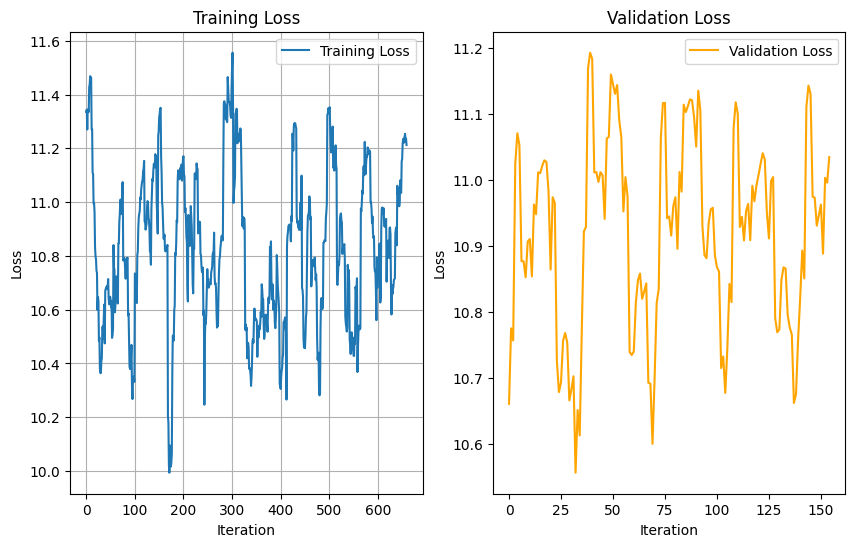

In [80]:
plot_loss(training_loss, val_loss)

ID00032637202181710233084 Average Loss: 104770.5390625
ID00035637202182204917484 Average Loss: 50470.60546875
ID00038637202182690843176 Average Loss: 10347.0615234375
ID00042637202184406822975 Average Loss: 38176.98046875


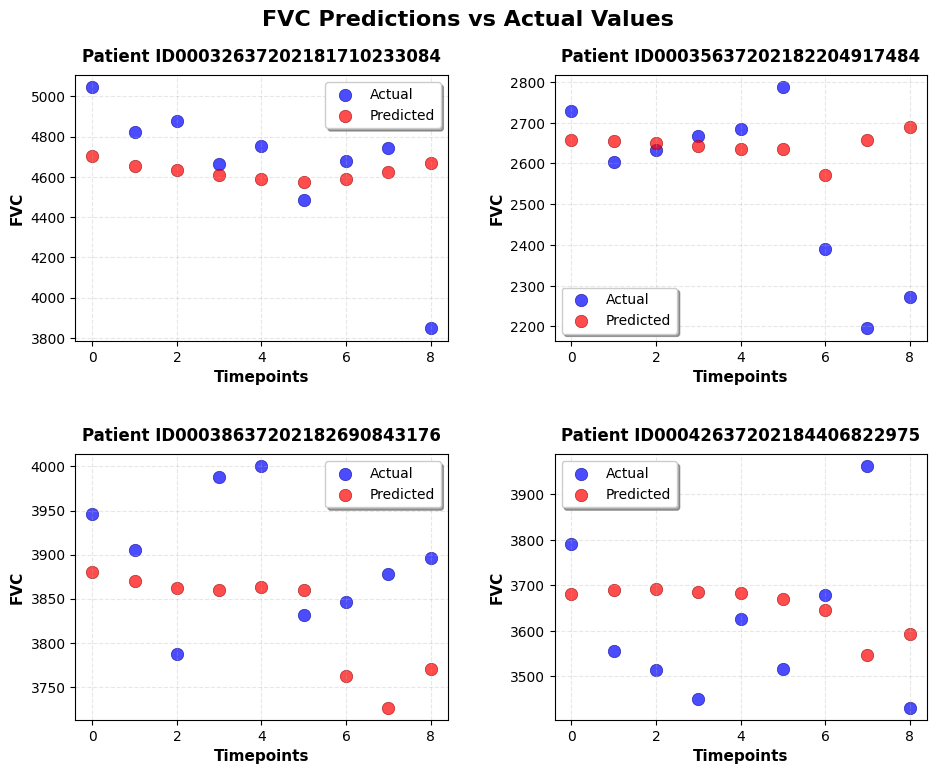

In [89]:
plot_patient_predict_samples(cnn_model, fc_model)

100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


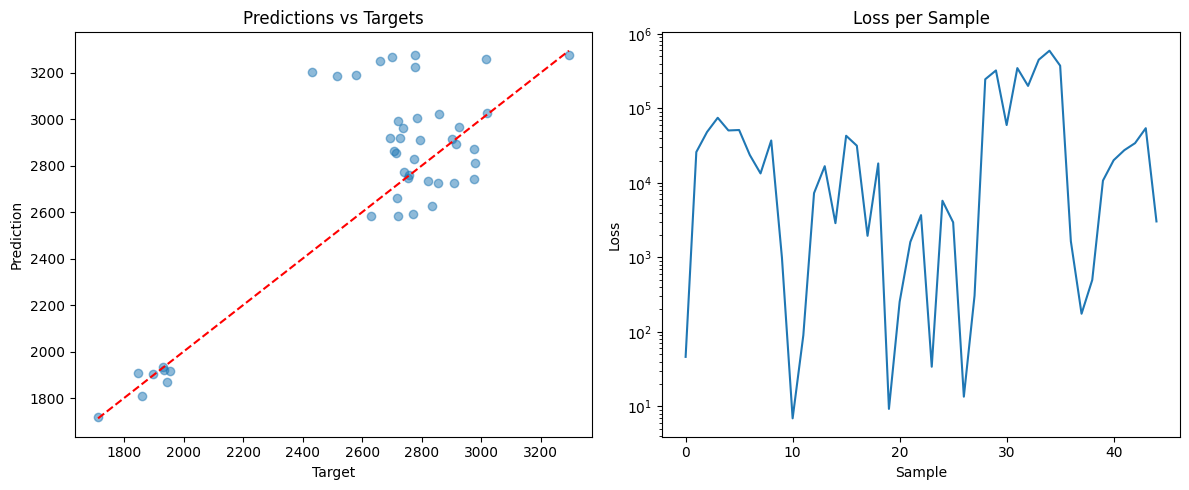

In [78]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

### Use Imagenet's 34 Layer Implementation

In [22]:
class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Follow Imagenet architecture (34 layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 6

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        ) + nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 11

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 5

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        ) + nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        ) * 2

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 512, 1, 1
        x = x.view(-1, 512)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=512+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0


100%|██████████| 136/136 [01:41<00:00,  1.34it/s]


Epoch 0 completed
Training Loss: 9445506.024748264
Validation Loss: 1492182.8608855396
Epoch 1


100%|██████████| 136/136 [01:41<00:00,  1.34it/s]


Epoch 1 completed
Training Loss: 2165604.31735988
Validation Loss: 260704.91879721748
Epoch 2


100%|██████████| 136/136 [01:41<00:00,  1.34it/s]


Epoch 2 completed
Training Loss: 451569.83776585915
Validation Loss: 79187.606344045
Epoch 3


100%|██████████| 136/136 [01:41<00:00,  1.35it/s]


Epoch 3 completed
Training Loss: 333556.89085138205
Validation Loss: 47415.2991904058
Epoch 4


100%|██████████| 136/136 [01:41<00:00,  1.33it/s]


Epoch 4 completed
Training Loss: 181935.34827541444
Validation Loss: 41532.40240815905


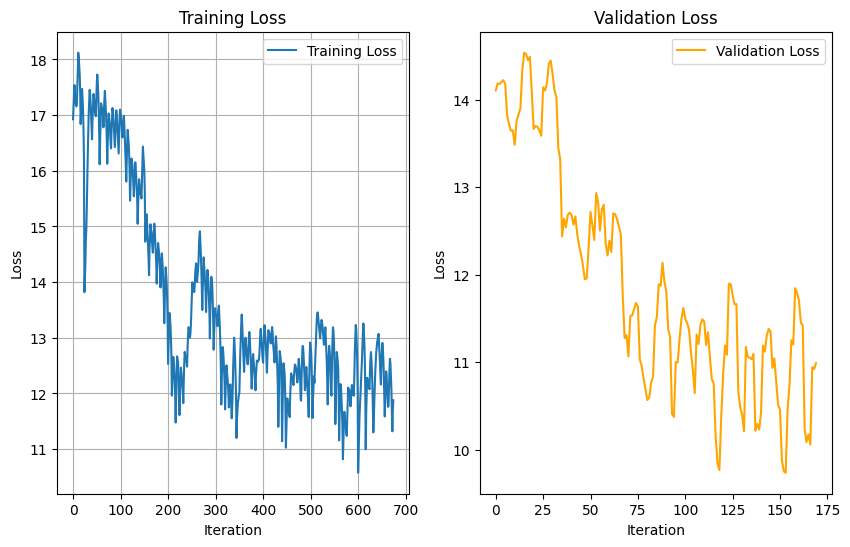

In [23]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_imagenet.txt'

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=5, scan_batch_size=64)
plot_loss(training_loss, val_loss)


Epoch 0


100%|██████████| 136/136 [01:42<00:00,  1.33it/s]


Epoch 0 completed
Training Loss: 200699.25884288986
Validation Loss: 66909.57344037824
Epoch 1


100%|██████████| 136/136 [01:41<00:00,  1.34it/s]


Epoch 1 completed
Training Loss: 131343.2174662484
Validation Loss: 41208.12258107397
Epoch 2


100%|██████████| 136/136 [01:40<00:00,  1.35it/s]


Epoch 2 completed
Training Loss: 429064.65835767426
Validation Loss: 43004.54604699029


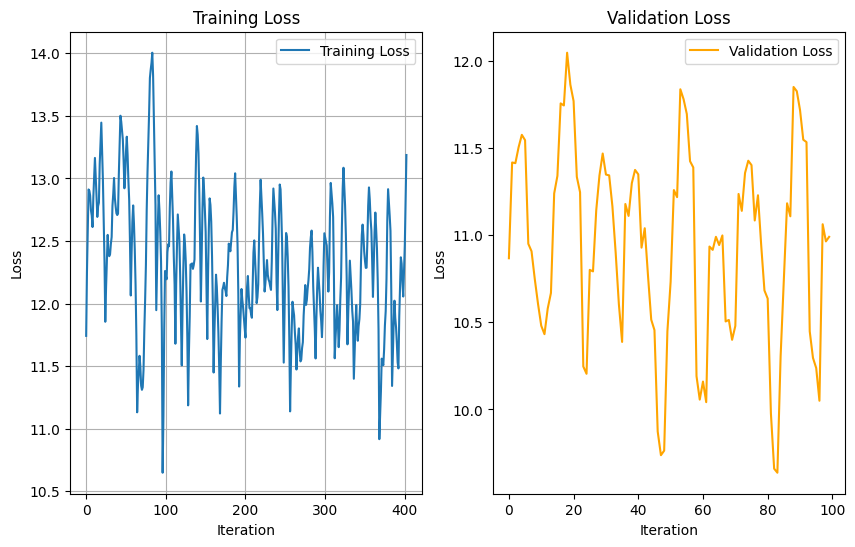

In [24]:
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=3, scan_batch_size=64)
plot_loss(training_loss, val_loss)

In [26]:
test_prediction, test_target = test_model(cnn_model, fc_model)
loss = torch.nn.MSELoss()
for i in range(len(test_prediction)):
    print(test_prediction[i], test_target[i], loss(test_prediction[i], test_target[i]))

100%|██████████| 5/5 [00:00<00:00,  8.92it/s]

tensor(2955.2466) tensor(3020) tensor(4193.0054)
tensor(2955.3071) tensor(2859) tensor(9275.0635)
tensor(2955.4287) tensor(2783) tensor(29731.6602)
tensor(2955.4895) tensor(2719) tensor(55927.2852)
tensor(2955.6719) tensor(2738) tensor(47381.0469)
tensor(2955.9761) tensor(2694) tensor(68631.4609)
tensor(2956.7661) tensor(2708) tensor(61884.5781)
tensor(2957.4958) tensor(2793) tensor(27058.8848)
tensor(2958.4692) tensor(2727) tensor(53578.0078)
tensor(2685.3762) tensor(2739) tensor(2875.5098)
tensor(2685.4978) tensor(2756) tensor(4970.5601)
tensor(2685.6194) tensor(2755) tensor(4813.6699)
tensor(2685.7412) tensor(2820) tensor(18025.4219)
tensor(2685.8623) tensor(2853) tensor(27935.0098)
tensor(2686.2275) tensor(2716) tensor(886.3994)
tensor(2686.9570) tensor(2833) tensor(21328.5488)
tensor(2687.7480) tensor(2771) tensor(6930.8877)
tensor(2688.7222) tensor(2628) tensor(3687.1816)
tensor(2688.7222) tensor(2719) tensor(916.7471)
tensor(1889.9749) tensor(1930) tensor(1602.0123)
tensor(1890.

### Add Residual Connections

In [29]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.input_conv(x))
        x = self.second_conv(x)
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

In [30]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=15)
plot_loss(training_loss, val_loss)

Epoch 0


100%|██████████| 136/136 [01:14<00:00,  1.82it/s]


Epoch 0 completed
Training Loss: 26451691.340833332
Validation Loss: 6375088.70625
Epoch 1


100%|██████████| 136/136 [01:07<00:00,  2.03it/s]


Epoch 1 completed
Training Loss: 10313839.908881972
Validation Loss: 1796454.9068446183
Epoch 2


100%|██████████| 136/136 [01:07<00:00,  2.01it/s]


Epoch 2 completed
Training Loss: 512546.4486246215
Validation Loss: 149511.6941560491
Epoch 3


100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Epoch 3 completed
Training Loss: 386953.0833448546
Validation Loss: 49395.72341920773
Epoch 4


100%|██████████| 136/136 [01:07<00:00,  2.03it/s]


Epoch 4 completed
Training Loss: 289783.0297261499
Validation Loss: 41739.187607805994
Epoch 5


100%|██████████| 136/136 [01:05<00:00,  2.07it/s]


Epoch 5 completed
Training Loss: 256691.3147747193
Validation Loss: 41653.05153889974
Epoch 6


100%|██████████| 136/136 [01:05<00:00,  2.08it/s]


Epoch 6 completed
Training Loss: 289105.40028264787
Validation Loss: 41814.991475703515
Epoch 7


100%|██████████| 136/136 [01:05<00:00,  2.08it/s]


Epoch 7 completed
Training Loss: 523477.94424128265
Validation Loss: 41554.720673802694
Epoch 8


100%|██████████| 136/136 [01:07<00:00,  2.02it/s]


Epoch 8 completed
Training Loss: 209136.86293978425
Validation Loss: 43571.092537344826
Epoch 9


100%|██████████| 136/136 [01:06<00:00,  2.03it/s]


Epoch 9 completed
Training Loss: 320754.6967118403
Validation Loss: 41783.48280666775
Epoch 10


100%|██████████| 136/136 [01:06<00:00,  2.03it/s]


Epoch 10 completed
Training Loss: 198838.48275851022
Validation Loss: 41443.26922769123
Epoch 11


 75%|███████▌  | 102/136 [00:50<00:16,  2.02it/s]


KeyboardInterrupt: 

### Use Batchnorm to stabilize weights

In [31]:
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    # Add batchnorm
    def __init__(self, input_dim, output_dim, stride):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.bn2(self.second_conv(x))
        if self.stride == 1:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(64, 128, 2, 4)
        self.conv4 = self._make_layer(128, 256, 2, 6)
        self.conv5 = self._make_layer(256, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [ResidualBlock(input_dim, output_dim, stride)]
        layers += [ResidualBlock(output_dim, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)

        return x

In [32]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_bn.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=8, scan_batch_size=64)
plot_loss(training_loss, val_loss)

Epoch 0


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 0 completed
Training Loss: 10171419.402083334
Validation Loss: 1875273.3816529675
Epoch 1


100%|██████████| 136/136 [01:58<00:00,  1.15it/s]


Epoch 1 completed
Training Loss: 1123270.351906467
Validation Loss: 154460.3026026747
Epoch 2


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 2 completed
Training Loss: 175707.74175649483
Validation Loss: 47230.468333183926
Epoch 3


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 3 completed
Training Loss: 195772.04956602785
Validation Loss: 42923.509592605165
Epoch 4


100%|██████████| 136/136 [01:58<00:00,  1.14it/s]


Epoch 4 completed
Training Loss: 311440.4012515108
Validation Loss: 43370.545636223294
Epoch 5


100%|██████████| 136/136 [01:59<00:00,  1.14it/s]


Epoch 5 completed
Training Loss: 240874.33300282937
Validation Loss: 43510.99670375612
Epoch 6


 74%|███████▍  | 101/136 [01:27<00:30,  1.15it/s]


KeyboardInterrupt: 

### Use Bottleneck blocks

In [11]:
from torch import nn
import torch.nn.functional as F

class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256):
        super(CNN, self).__init__()
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2))
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 23)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(x.size(0), -1)

        return x

class FCLayer(nn.Module):
    def __init__(self, input_dim=2048+3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch 0


100%|██████████| 136/136 [06:05<00:00,  2.69s/it]


Epoch 0 completed
Training Loss: 667819.0930362048
Validation Loss: 97155.5853611056
Epoch 1


100%|██████████| 136/136 [06:16<00:00,  2.77s/it]


Epoch 1 completed
Training Loss: 209757.71511391798
Validation Loss: 46256.967478790284
Epoch 2


100%|██████████| 136/136 [06:18<00:00,  2.79s/it]


Epoch 2 completed
Training Loss: 148185.1695085537
Validation Loss: 44207.440449318354
Epoch 3


100%|██████████| 136/136 [06:30<00:00,  2.87s/it]


Epoch 3 completed
Training Loss: 290834.1511991519
Validation Loss: 40749.76325650778
Epoch 4


100%|██████████| 136/136 [06:28<00:00,  2.86s/it]


Epoch 4 completed
Training Loss: 270430.78575109807
Validation Loss: 44281.47471906851
Epoch 5


100%|██████████| 136/136 [05:58<00:00,  2.64s/it]


Epoch 5 completed
Training Loss: 325952.886311521
Validation Loss: 42322.56000130124


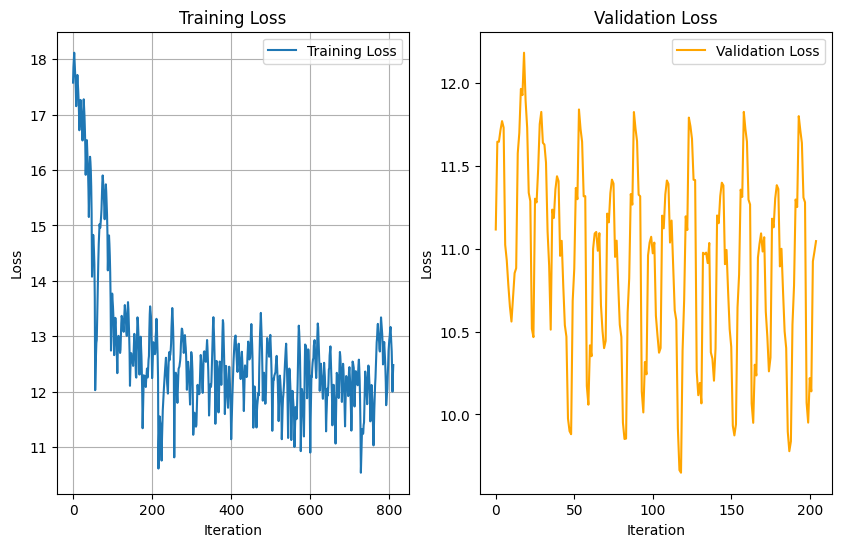

In [12]:
cnn_model = CNN().to(device)
fc_model = FCLayer().to(device)

log_file = 'training_log_resnet_152.txt'
training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=6, scan_batch_size=64)
plot_loss(training_loss, val_loss)

### Analyze top and bottom half of lung separately

In [10]:
from torch import nn
import torch.nn.functional as F

from torch import nn
import torch.nn.functional as F


class BottleneckResBlock(nn.Module):
    # Deepen model, use 101 layer resnet architecture
    def __init__(self, input_dim, output_dim, stride, first_block=False, dropout_rate=0.1):
        super(BottleneckResBlock, self).__init__()
        self.stride = stride
        self.input_conv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.second_conv = nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.third_conv = nn.Conv2d(output_dim, output_dim * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        self.first_block = first_block

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.input_conv(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.second_conv(x)))
        x = self.dropout(x)
        x = self.bn3(self.third_conv(x))

        # If not convx_1
        if not self.first_block:
            x += residual
        x = F.relu(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_dim=256, dropout_rate=0.1):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        # Add Residual Connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d((3, 3), stride=(2, 2)),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = self._make_layer(64, 64, 1, 3)
        self.conv3 = self._make_layer(256, 128, 2, 4)
        self.conv4 = self._make_layer(512, 256, 2, 6)
        self.conv5 = self._make_layer(1024, 512, 2, 3)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_final = nn.Dropout(p=dropout_rate * 2)

    def _make_layer(self, input_dim, output_dim, stride, num_blocks):
        layers = [BottleneckResBlock(input_dim, output_dim, stride, first_block=True, dropout_rate=self.dropout_rate)]
        layers += [BottleneckResBlock(output_dim * 4, output_dim, 1, dropout_rate=self.dropout_rate) for _ in range(num_blocks - 1)]
        return nn.Sequential(*layers)

    def forward(self, scans: torch.Tensor):
        # Scans: List of num_slices, 1, 256, 256
        x = self.conv1(scans) # num_slices, 64, 63, 63
        x = self.conv2(x) # num_slices, 64, 63, 63
        x = self.conv3(x) # num_slices, 128, 32, 32
        x = self.conv4(x) # num_slices, 256, 16, 16
        x = self.conv5(x) # num_slices, 512, 8, 8
    
        x = self.global_pool(x) # num_slices, 256, 1, 1
        x = x.view(-1, 512)
        x = self.dropout_final(x)

        return x

class FCLayer(nn.Module):
    def __init__(self, partition_count, dropout_rate=0.3):
        super(FCLayer, self).__init__()
        self.fc1 = nn.Linear(512 * partition_count + 3, 512 * partition_count // 4)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512 * partition_count // 4, 100)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, features, weeks, initial_FVC, initial_FVC_weeks):
        x = torch.cat([features, weeks, initial_FVC, initial_FVC_weeks])
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [ ]:
from datetime import datetime

from preprocess import get_preprocessed_scan

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_scans(patient_id: str, patient_scan_count: int, partition_count: int, scan_batch_size: int) -> torch.Tensor:
    scans = []
    scan_per_partition = math.floor(patient_scan_count / partition_count)
    for part_idx in range(partition_count):
        partition = []
        part_start, part_end = part_idx * scan_per_partition, (part_idx + 1) * scan_per_partition
        skip_size = max(1, round(scan_per_partition / scan_batch_size))
        for scan_idx in range(part_start, part_end, skip_size):
            scan = get_preprocessed_scan(data_dir, patient_id, scan_idx)
            if scan is None:
                continue
            scan = torch.tensor(scan, dtype=torch.float32, device=device)
            partition.append(scan)
        scans.append(torch.stack(partition))
    return scans

def train_model(cnn_model: CNN, fc_model: FCLayer, log_file: str, epoch=6, learning_rate=0.001, partition_count=2, scan_batch_size=32):
    torch.cuda.empty_cache()

    training_loss = []
    val_loss = []

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(cnn_model.parameters()) + list(fc_model.parameters()), lr=learning_rate
    )

    with open(log_file, 'w') as f:
        f.write(f"Training started: {datetime.now()}\n")
        f.write("="*70 + "\n\n")

    for epoch in range(epoch):
        print(f"Epoch {epoch}")
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch}\n")
        cnn_model.train()
        fc_model.train()

        patient_count = 0
        # accum_loss = 0
        patient_list = list(train_x.keys())
        random.shuffle(patient_list)
        for patient_id in tqdm(patient_list):
            # if patient_count % 4 == 0:
            #     optimizer.zero_grad()
            #     accum_loss = 0

            patient_scan_count = scan_count[patient_id]
            scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)


            x = train_x[patient_id]
            y = train_y[patient_id]

            # Accumulate loss for stat purpose
            accum_loss = 0

            # For each datapoint, forward pass and backward pass
            for i in range(len(x)):
                optimizer.zero_grad()

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                # Forward Pass
                output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                # accum_loss += criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                loss.backward()
                optimizer.step()
                accum_loss += loss.item()


            # accum_loss.backward()
            # optimizer.step()
            training_loss.append(accum_loss / max(len(x), 1))
            
            if patient_count == 130:
                print(f"Feature mean: {features.mean():.4f}")
                print(f"Feature std: {features.std():.4f}")
            patient_count += 1
            # Update parameters based on batch of 8 patients
            # if patient_count % 4 == 3:
            #     accum_loss.backward()
            #     optimizer.step()
            #     print(f"Feature mean: {features.mean():.4f}")
            #     print(f"Feature std: {features.std():.4f}")
            #     with open(log_file, "a") as f:
            #         f.write(f"Epoch {epoch}, Loss: {accum_loss.item() / max(len(x), 1)}\n")
            #         training_loss.append(accum_loss / max(len(x), 1))
            #     del accum_loss
            # patient_count += 1
            

        
            del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, accum_loss
            torch.cuda.empty_cache()

        # Validation
        with torch.no_grad():
            for patient_id in list(val_x.keys()):
                optimizer.zero_grad()

                patient_scan_count = scan_count[patient_id]
                scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)

                features = []
                for i in range(partition_count):
                    feature = cnn_model.forward(scans[i])
                    features.append(torch.mean(feature, dim=0))
                features = torch.cat(features, dim=0).flatten()

                x = val_x[patient_id]
                y = val_y[patient_id]

                # Accumulate for all datapoints of patient
                accum_loss = 0
                for i in range(len(x)):
                    weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
                    initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

                    # Forward Pass
                    output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
                    
                    loss = criterion(output, torch.tensor(y[i], dtype=torch.float32, device=device))
                    accum_loss += loss.item()

                with open(log_file, "a") as f:
                    f.write(f"Epoch {epoch}, Val Loss: {accum_loss / max(len(x), 1)}\n")
                val_loss.append(accum_loss / max(len(x), 1))

                if len(x) == 0:
                    print(f"Patient {patient_id} has no data during validation")

                del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output, loss
                torch.cuda.empty_cache()

        tqdm.write(f"Epoch {epoch} completed")
        # Last 10 training loss, last 10 validation loss
        tqdm.write(f"Training Loss: {sum(training_loss[-10:]) / 10}")
        tqdm.write(f"Validation Loss: {sum(val_loss[-10:]) / 10}")
    return training_loss, val_loss

In [12]:
from preprocess import get_test_preprocessed_scan

def test_model(cnn_models, fc_model, partition_count=2, scan_batch_size=64):
    for cnn_model in cnn_models:
        cnn_model.eval()
    fc_model.eval()

    test_predictions = []
    test_target = []

    for patient_id in tqdm(test_patient_ids):
        patient_scan_count = test_scan_count[patient_id]
        scans = get_scans(patient_id, patient_scan_count, partition_count, scan_batch_size)
        features = []
        for i in range(partition_count):
            feature = cnn_models[i].forward(scans[i])
            features.append(torch.mean(feature, dim=0))
        features = torch.cat(features, dim=0).flatten()

        x = test_x[patient_id]
        y = test_y[patient_id]

        for i in range(len(x)):
            weeks = torch.tensor(x[i]['Weeks'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC = torch.tensor(x[i]['initial_FVC'], dtype=torch.float32, device=device).unsqueeze(0)
            initial_FVC_weeks = torch.tensor(x[i]['initial_weeks'], dtype=torch.float32, device=device).unsqueeze(0)

            output = fc_model.forward(features, weeks, initial_FVC, initial_FVC_weeks).squeeze()
            test_predictions.append(output.item())
            test_target.append(y[i])

        del x, y, features, scans, weeks, initial_FVC, initial_FVC_weeks, output
        torch.cuda.empty_cache()
    
    return torch.tensor(test_predictions), torch.tensor(test_target)

Epoch 0


 96%|█████████▋| 131/136 [04:55<00:10,  2.07s/it]

Feature mean: 0.3726
Feature std: 0.0618


100%|██████████| 136/136 [05:07<00:00,  2.26s/it]


Epoch 0 completed
Training Loss: 155185.12353634305
Validation Loss: 179111.58716387922
Epoch 1


 96%|█████████▋| 131/136 [04:24<00:11,  2.29s/it]

Feature mean: 0.2328
Feature std: 0.0434


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 1 completed
Training Loss: 129201.75251117055
Validation Loss: 245942.50359031782
Epoch 2


 96%|█████████▋| 131/136 [04:23<00:10,  2.15s/it]

Feature mean: 0.1256
Feature std: 0.0294


100%|██████████| 136/136 [04:34<00:00,  2.01s/it]


Epoch 2 completed
Training Loss: 203600.0089995999
Validation Loss: 180476.9363442858
Epoch 3


 96%|█████████▋| 131/136 [04:23<00:09,  1.89s/it]

Feature mean: 0.6432
Feature std: 0.0568


100%|██████████| 136/136 [04:33<00:00,  2.01s/it]


Epoch 3 completed
Training Loss: 178461.12029605443
Validation Loss: 178910.1704472754
Epoch 4


 96%|█████████▋| 131/136 [04:26<00:07,  1.48s/it]

Feature mean: 0.0780
Feature std: 0.0302


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 4 completed
Training Loss: 201670.3846994916
Validation Loss: 186100.09874464248
Epoch 5


 96%|█████████▋| 131/136 [04:24<00:06,  1.28s/it]

Feature mean: 0.0459
Feature std: 0.0209


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 5 completed
Training Loss: 133576.05266017278
Validation Loss: 164550.67864883423
Epoch 6


 96%|█████████▋| 131/136 [04:25<00:12,  2.40s/it]

Feature mean: 0.0490
Feature std: 0.0177


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 6 completed
Training Loss: 179841.28394714356
Validation Loss: 252408.94001993816
Epoch 7


 96%|█████████▋| 131/136 [04:25<00:09,  1.93s/it]

Feature mean: 0.0113
Feature std: 0.0077


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 7 completed
Training Loss: 135129.31214817593
Validation Loss: 246303.93169339924
Epoch 8


 96%|█████████▋| 131/136 [04:25<00:09,  1.88s/it]

Feature mean: 0.0109
Feature std: 0.0098


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 8 completed
Training Loss: 168431.17493760266
Validation Loss: 217720.31133607653
Epoch 9


 96%|█████████▋| 131/136 [04:21<00:09,  1.99s/it]

Feature mean: 0.0040
Feature std: 0.0069


100%|██████████| 136/136 [04:34<00:00,  2.02s/it]


Epoch 9 completed
Training Loss: 126111.29242416487
Validation Loss: 219540.72166845325


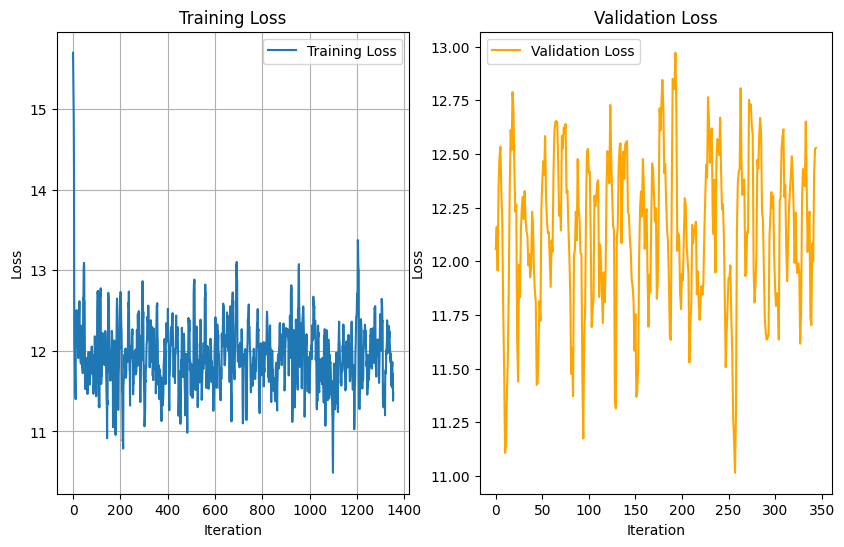

In [14]:
log_file = 'training_log_top_bottom_analysis.txt'

partition_count = 1

# cnn_models = [CNN().to(device) for _ in range(partition_count)]
cnn_model = CNN().to(device)
fc_model = FCLayer(partition_count).to(device)

training_loss, val_loss = train_model(cnn_model, fc_model, log_file, epoch=10, partition_count=1, scan_batch_size=64)
plot_loss(training_loss, val_loss)

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


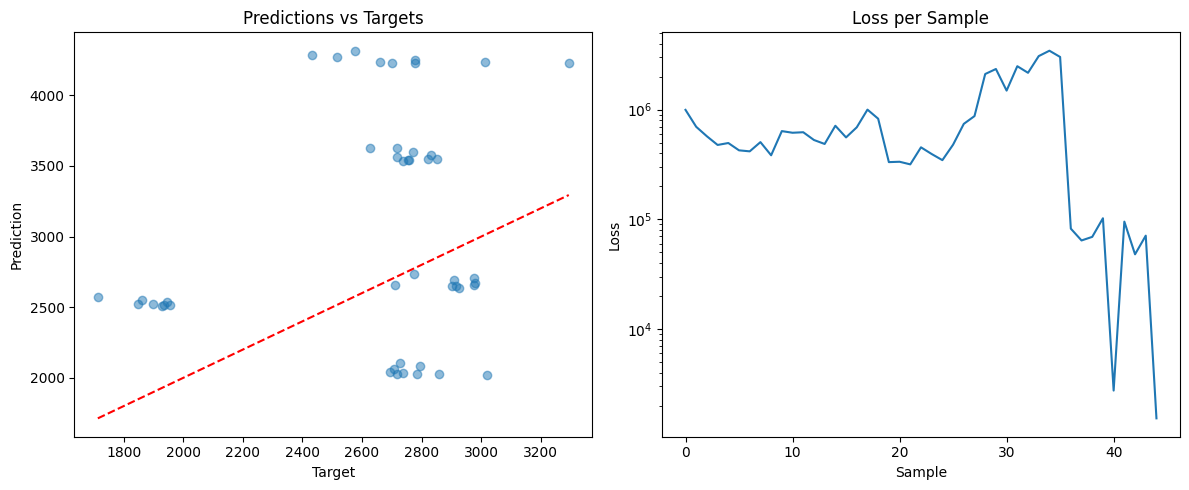

In [24]:
test_prediction, test_target = test_model(cnn_models, fc_model)
loss = torch.nn.MSELoss()
plot_test_results(test_target, test_prediction, [loss(test_prediction[i], test_target[i]) for i in range(len(test_prediction))])

In [17]:
predictions = test_prediction
targets = test_target
# 1. Check if model is just predicting initial_FVC
print("Correlation between predictions and initial_FVC:")
initial_fvc_vals = [val_x[pid][i]['initial_FVC'] for pid in val_x.keys() for i in range(len(val_x[pid]))]
print(f"Corr(pred, initial_FVC): {np.corrcoef(predictions, initial_fvc_vals)[0,1]:.4f}")
print(f"Corr(pred, targets): {np.corrcoef(predictions, targets)[0,1]:.4f}")

# 2. Check unique prediction values (should be many, not just a few)
unique_preds = np.unique(np.round(predictions, -1))  # Round to nearest 10
print(f"Number of distinct prediction values (±10ml): {len(unique_preds)}")
print(f"Most common predictions: {np.round(np.bincount(np.round(predictions).astype(int)).argsort()[-5:], -1)}")

# 3. Baseline comparison
baseline_predictions = initial_fvc_vals  # Just predict initial_FVC
baseline_mae = np.mean(np.abs(np.array(targets) - np.array(baseline_predictions)))
model_mae = np.mean(np.abs(np.array(targets) - np.array(predictions)))
print(f"Baseline MAE (just initial_FVC): {baseline_mae:.1f}")
print(f"Model MAE: {model_mae:.1f}")
print(f"Improvement: {baseline_mae - model_mae:.1f} ml")

# 4. Check prediction variance
print(f"Target std: {np.std(targets):.1f}")
print(f"Prediction std: {np.std(predictions):.1f}")
# If prediction std << target std, model is underconfident/conservativepse
# 4. **Try simpler baseline** - predict `initial_FVC + weeks * learned_rate` to establish lower bound
# 5. **Increase FC layer depth** - add 1-2 more layers with dropout
# 6. **Use Huber loss instead of MSE** - more robust to outliers
# 7. **Add learning rate scheduler** - may be stuck in local minimum

# The horizontal banding is the **clearest signal** that your model has collapsed to predicting only a few discrete values rather than learning continuous relationships. This is often caused by incorrect gradient flow (like `retain_graph=True` issue) or insufficient model capacity in the FC layers.

Correlation between predictions and initial_FVC:


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 45 and the array at index 1 has size 314